# Multi modal model

In [ ]:
%pip install --upgrade pip
%pip install tensorflow
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers
%pip install git+https://github.com/paulgavrikov/visualkeras

In [ ]:
import yfinance as yf
import re
import nltk
import tensorflow as tf
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
import torch.utils.data as td
import pytorch_lightning as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split
%matplotlib inline
nltk.download("stopwords")
from sklearn.preprocessing import MinMaxScaler
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
# from keras.optimizer import Adam
# from keras.optimizers.Adam
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import TCN, Dense

from keras.layers import LSTM,Conv1D, Dense, Embedding,TCN, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate
from keras.layers import LSTM,Conv1D, Dense, Embedding,GlobalMaxPooling1D, Input,Bidirectional, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

# Fetch financial record from 1st January 2015 - 31st May 2021

In [ ]:
start_date ='2014-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

In [ ]:
price.head()

In [ ]:
price = price.reset_index()
price.index = pd.to_datetime(price['Date'], format='%Y-%m-%d')
# price = price.drop(['Date'], axis=1)

In [ ]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

# Calculate the percentage change in the Close price
price['Close_pct_change'] = price['Close'].pct_change()

# Create a binary column indicating if the Close price increased (1) or decreased (0)
price['Close_increase'] = (price['Close_pct_change'] > 0).astype(int)

# Fill any NaN values in the new columns with 0 (for the first row)
price['Close_pct_change'].fillna(0, inplace=True)
price['Close_increase'].fillna(0, inplace=True)

# Drop the 'Close_pct_change' column if you no longer need it
price.drop('Close_pct_change', axis=1, inplace=True)


In [ ]:
price.head()

In [ ]:
price.shape

### Compute moving average

In [ ]:
# We will compute 7, 14, 21 simple moving average moving average 
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)
price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']

In [ ]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [ ]:
price.shape

In [ ]:
price.tail(5)

In [ ]:
price = price.dropna()

In [ ]:
price.describe()

In [ ]:
price_corr = price.drop(['Date'], axis=1)

In [ ]:
price_corr.corr()

In [ ]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

In [ ]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [ ]:
price['Label'].value_counts()

In [ ]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [ ]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

### Process tweets

In [ ]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [ ]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [ ]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [ ]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [ ]:
tweets['text_split'] = tweets['text_split'].str[:200]

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        return 1  # Positive sentiment
    elif compound_score <= -0.05:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Apply sentiment analysis and add a binary sentiment column
tweets['sentiment'] = tweets['text_split'].apply(get_sentiment)


In [ ]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


In [ ]:
# Convert the 'Date' column to datetime
tweets['Date'] = pd.to_datetime(tweets['Date'])

# Group by 'Date' and calculate the most frequent sentiment for each day
tweets = tweets.groupby('Date')['sentiment'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Display the consolidated DataFrame
print(tweets)


In [ ]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


In [ ]:
price['Date'] = pd.to_datetime(price['Date'])

In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [ ]:
tweets

In [ ]:
price = price.drop(['Date'],axis=1)

In [ ]:
multi_modal = tweets.merge(price, how='outer', on=['Date'])

In [ ]:
multi_modal = multi_modal.dropna()

In [ ]:
multi_modal.index = pd.to_datetime(multi_modal['Date'], format='%Y-%m-%d')

In [ ]:
multi_modal = multi_modal.dropna()

In [ ]:
multi_modal = multi_modal.drop(['Date'], axis=1)

In [ ]:
multi_modal['change_label'] = multi_modal['change_label'].apply(lambda x: 1 if x else 0)

In [ ]:
multi_modal.info()

In [ ]:
col = list(multi_modal)[0:len(multi_modal)]

In [ ]:
df_for_training = multi_modal[col].astype(float)
scaler  = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)


In [ ]:
X,y = df_to_X_y(df_for_training_scaled)

In [ ]:
import numpy as np

def df_to_X_y_with_past_and_future_multivirate(df,df_scaled, n_future, n_past):
    X = []
    y = []
    for i in range(n_past, len(df_scaled) - n_future + 1):
        # X.append(df.iloc[i - n_past:i, :].values)
        # y.append(df.iloc[i + n_future - 1:i + n_future, 0].values)

        X.append(df_scaled[i - n_past:i, 0:df.shape[1]])
        y.append(df_scaled[i + n_future - 1:i + n_future, 0])
    X, y = np.array(X), np.array(y)
    return X, y


In [ ]:
n = len(multi_modal)

In [ ]:
X,y = df_to_X_y_with_past_and_future_multivirate(df_for_training,df_for_training_scaled,1,14)
X_train, y_train = X[0:int(n*0.7)],y[0:int(n*0.7)]
X_val, y_val = X[int(n*0.7):int(n*0.9)],y[int(n*0.7):int(n*0.9)]
X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]


### Utility methods

In [ ]:
def plot_training_history(history, name):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{name}_loss_plot.png')  # Save the loss plot
    plt.show()

    plt.plot(history.history['mean_absolute_error'], label='train_mae')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.savefig(f'{name}_mae_plot.png')  # Save the MAE plot
    plt.show()

In [ ]:
EPOCHS = 50

In [ ]:
def compile_and_fit(model, x, y, epochs=EPOCHS, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(x, y, epochs= epochs,batch_size=32, validation_split=0.33,shuffle=False, callbacks=[early_stopping])
    return history

### Baseline model

### Vanilla LSTM layer

In [ ]:
base_model_1 = Sequential()
base_model_1.add(LSTM(32,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
base_model_1.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_1, to_file='base_model_1.png').show() # write and show

### Standard LSTM layer with 32 units

In [ ]:
base_model_2 = Sequential()
base_model_2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))  # Add an LSTM layer
base_model_2.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_2, to_file='base_model_2.png').show() # write and show

### Bidirectional LSTM layer with 64 units

In [ ]:
base_model_3 = Sequential()
base_model_3.add(Bidirectional(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))  # Add a Bidirectional LSTM layer
base_model_3.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_3, to_file='base_model_3.png').show() # write and show

In [ ]:
base_model_4 = Sequential()
base_model_4.add(Conv1D(64, kernel_size=3, activation='relu'))
base_model_4.add(MaxPooling1D(pool_size=2))
base_model_4.add(LSTM(64))
base_model_4.add(Dense(32, activation='relu'))
base_model_4.add(Dropout(0.2))
base_model_4.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_4, to_file='text_model.png').show() 

### ConvLSTM model

In [ ]:
# Create a ConvLSTM model
base_model_5 = Sequential()
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1],X_train.shape[2],3)))
base_model_5.add(BatchNormalization())
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
base_model_5.add(BatchNormalization())
base_model_5.add(Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))


### Gated Recurrent Unit (GRU)

In [ ]:
base_model_6 = Sequential()
base_model_6.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_6.add(Dense(y_train.shape[1], activation='softmax'))

### Bidirectional LSTM (BiLSTM)

In [ ]:
base_model_7 = Sequential()
base_model_7.add(Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_7.add(Dense(y_train.shape[1], activation='softmax'))

### Stacked LSTM

In [ ]:
base_model_8 = Sequential()
base_model_8.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_8.add(LSTM(64, return_sequences=True))
base_model_8.add(LSTM(64))
base_model_8.add(Dense(y_train.shape[1], activation='softmax'))

### LSTM with Attention Mechanism

In [ ]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = LSTM(64, return_sequences=True)(inputs)
attention = Attention()([lstm, lstm])  # Add attention mechanism
output = Dense(y_train.shape[1], activation='softmax')(attention)
base_model_9 = Model(inputs, output)

### Temporal Convolutional Networks (TCN):

In [ ]:
%pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

In [ ]:
base_model_10 = Sequential()
base_model_10.add(TCN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_10.add(Dense(y_train.shape[1], activation='softmax'))

In [ ]:
base_model_11 = Sequential()
base_model_11.add(LSTM(units=64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
base_model_11.add(LSTM(units=32,activation='relu', return_sequences=False))
base_model_11.add(Dropout(0.2))
base_model_11.add(Dense(y_train.shape[1]))
# cp = ModelCheckpoint('model1/', save_best_only=True)
# base_model_11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
base_model_12 = Sequential()
base_model_12.add(LSTM(64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
base_model_12.add(LSTM(32,activation='relu',return_sequences=False))
base_model_12.add(Dense(y_train.shape[1]))

In [ ]:
models = [
    ('Vanilla LSTM layer', base_model_1),
    # ('Standard LSTM layer with 32 units', base_model_2),
    # ('Bidirectional LSTM layer with 64 units', base_model_3),
    ('Base model 4', base_model_4),
    # ('ConvLSTM model', base_model_5),
    ('Gated Recurrent Unit (GRU)', base_model_6),
    ('Bidirectional LSTM (BiLSTM)', base_model_7),
    ('Stacked LSTM', base_model_8),
    # ('LSTM with Attention Mechanism', base_model_9),
    # ('Temporal Convolutional Networks (TCN)', base_model_10),
    ('LSTM with Attention', base_model_11),
    ('Base model 12', base_model_12)
]

### Build and train the model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Training Vanilla LSTM layer...
Epoch 1/5
33/33 [==============================] - 2s 24ms/step - loss: 1.4657 - mean_absolute_error: 0.2864 - val_loss: 0.4650 - val_mean_absolute_error: 0.2398
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.4614 - mean_absolute_error: 0.3036 - val_loss: 0.4673 - val_mean_absolute_error: 0.2450
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 1.4601 - mean_absolute_error: 0.3050 - val_loss: 0.4688 - val_mean_absolute_error: 0.2480
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.4585 - mean_absolute_error: 0.3048 - val_loss: 0.4703 - val_mean_absolute_error: 0.2510
Epoch 5/5
33/33 [==============================] - 1s 18ms/step - loss: 1.4569 - mean_absolute_error: 0.3054 - val_loss: 0.4717 - val_mean_absolute_error: 0.2538


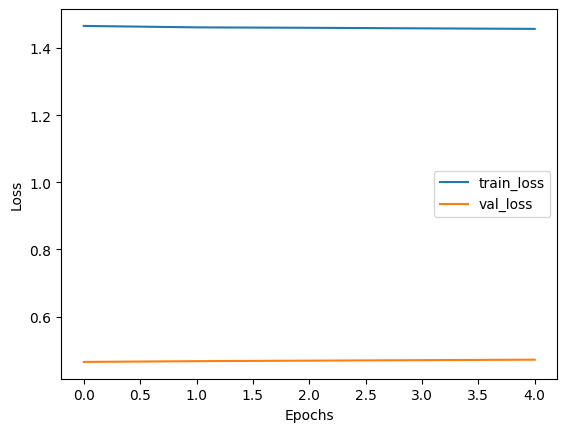

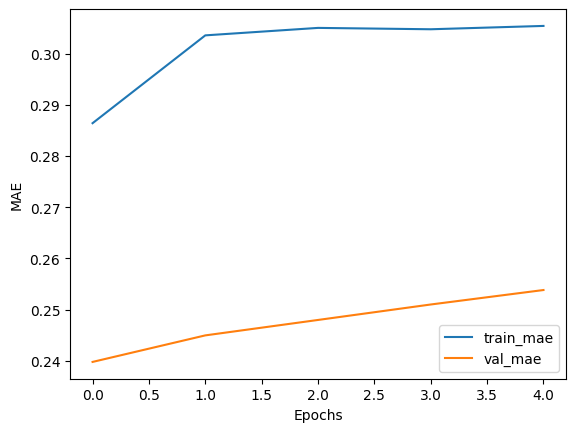

7/7 [==============================] - 0s 5ms/step
Vanilla LSTM layer MAE: 0.3472999079493304
Vanilla LSTM layer MSE: 0.13662620204124473
Training Base model 4...
Epoch 1/5
33/33 [==============================] - 2s 29ms/step - loss: 1.2995 - mean_absolute_error: 0.2884 - val_loss: 0.6621 - val_mean_absolute_error: 0.3835
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 1.2285 - mean_absolute_error: 0.3098 - val_loss: 0.6862 - val_mean_absolute_error: 0.3908
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 1.2906 - mean_absolute_error: 0.3088 - val_loss: 0.6943 - val_mean_absolute_error: 0.3917
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 1.2753 - mean_absolute_error: 0.3090 - val_loss: 0.7210 - val_mean_absolute_error: 0.4118
Epoch 5/5
33/33 [==============================] - 1s 19ms/step - loss: 1.2349 - mean_absolute_error: 0.3097 - val_loss: 0.7327 - val_mean_absolute_error: 0.4186


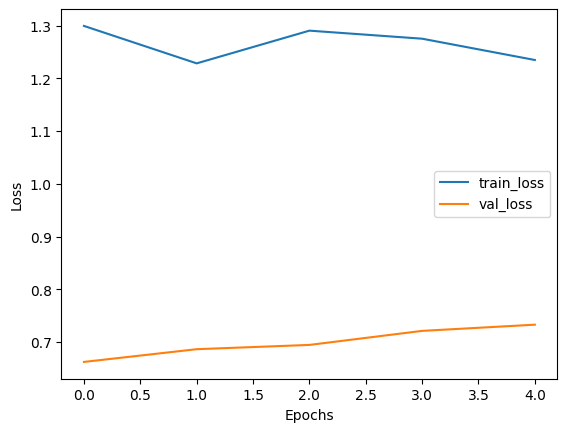

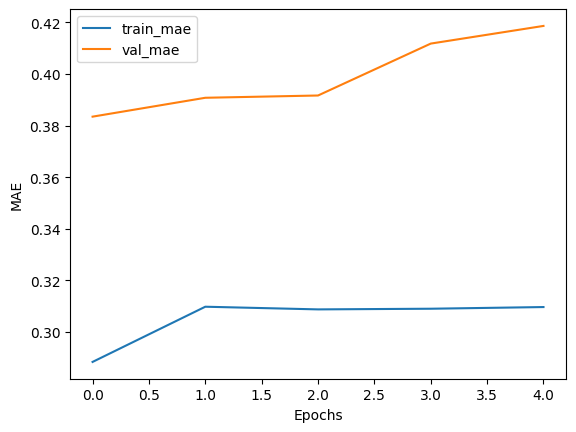

7/7 [==============================] - 0s 5ms/step
Base model 4 MAE: 0.46048404958889755
Base model 4 MSE: 0.24884913391157196
Training Gated Recurrent Unit (GRU)...
Epoch 1/5
33/33 [==============================] - 2s 25ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 5/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390


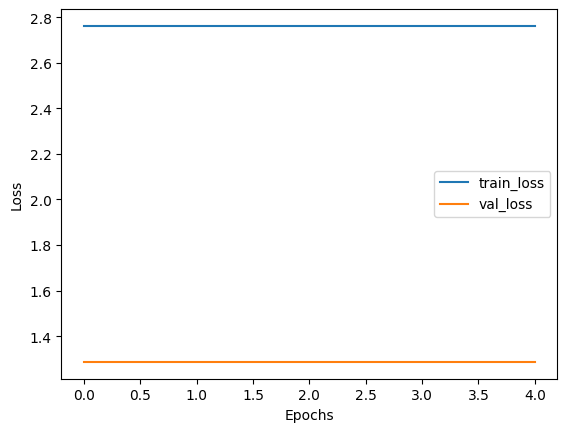

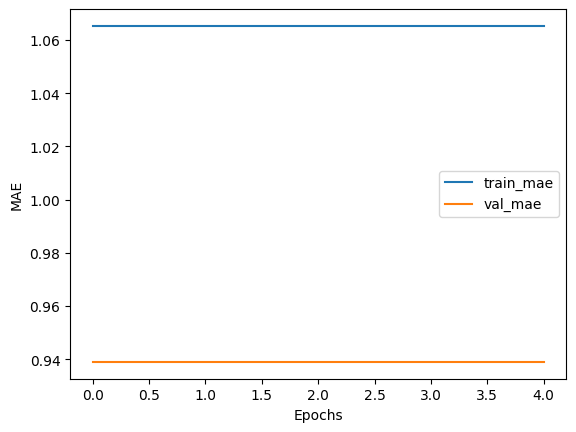

7/7 [==============================] - 0s 6ms/step
Gated Recurrent Unit (GRU) MAE: 0.8994022236788763
Gated Recurrent Unit (GRU) MSE: 0.8089243599585069
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/5
33/33 [==============================] - 4s 51ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 2/5
33/33 [==============================] - 1s 39ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 3/5
33/33 [==============================] - 1s 38ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 4/5
33/33 [==============================] - 1s 38ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 5/5
33/33 [==============================] - 1s 38ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.93

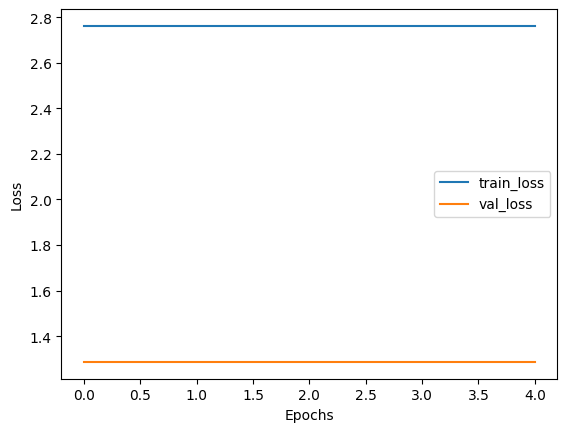

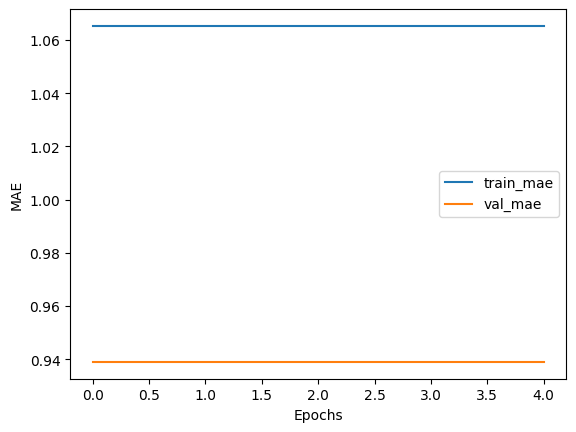

7/7 [==============================] - 0s 10ms/step
Bidirectional LSTM (BiLSTM) MAE: 0.8994022236788763
Bidirectional LSTM (BiLSTM) MSE: 0.8089243599585069
Training Stacked LSTM...
Epoch 1/5
33/33 [==============================] - 6s 95ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 2/5
33/33 [==============================] - 2s 73ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 3/5
33/33 [==============================] - 2s 74ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 4/5
33/33 [==============================] - 2s 73ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 5/5
33/33 [==============================] - 2s 73ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390


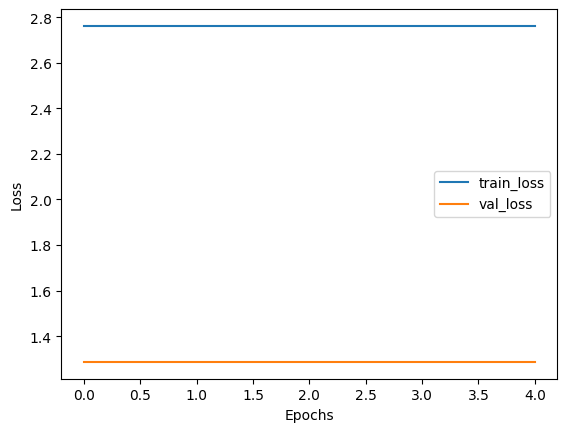

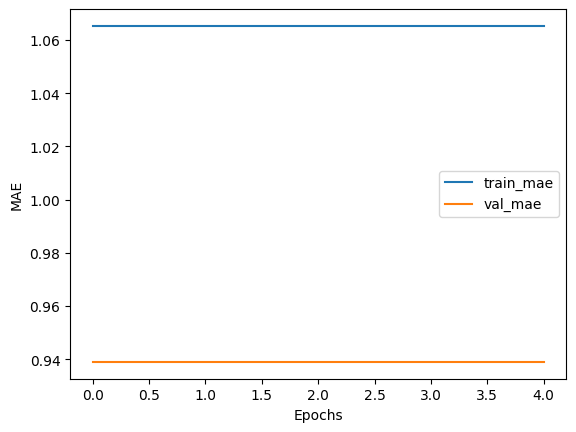

7/7 [==============================] - 1s 20ms/step
Stacked LSTM MAE: 0.8994022236788763
Stacked LSTM MSE: 0.8089243599585069
Training LSTM with Attention...
Epoch 1/5
33/33 [==============================] - 3s 44ms/step - loss: 1.4616 - mean_absolute_error: 0.2988 - val_loss: 0.6271 - val_mean_absolute_error: 0.3438
Epoch 2/5
33/33 [==============================] - 1s 39ms/step - loss: 1.4636 - mean_absolute_error: 0.3087 - val_loss: 0.6434 - val_mean_absolute_error: 0.3635
Epoch 3/5
33/33 [==============================] - 1s 39ms/step - loss: 1.4290 - mean_absolute_error: 0.3148 - val_loss: 0.6534 - val_mean_absolute_error: 0.3747
Epoch 4/5
33/33 [==============================] - 1s 38ms/step - loss: 1.4731 - mean_absolute_error: 0.3211 - val_loss: 0.6507 - val_mean_absolute_error: 0.3724
Epoch 5/5
33/33 [==============================] - 1s 38ms/step - loss: 1.4584 - mean_absolute_error: 0.3292 - val_loss: 0.6489 - val_mean_absolute_error: 0.3765


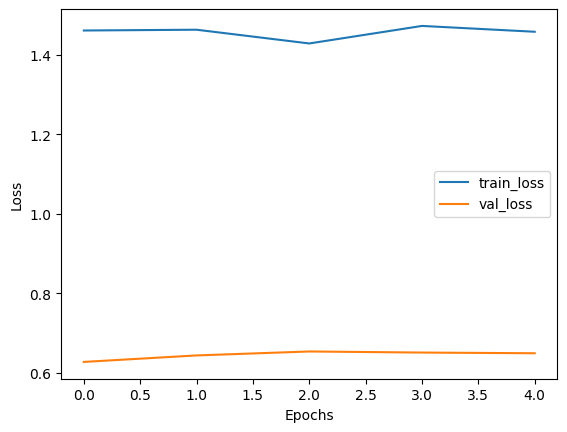

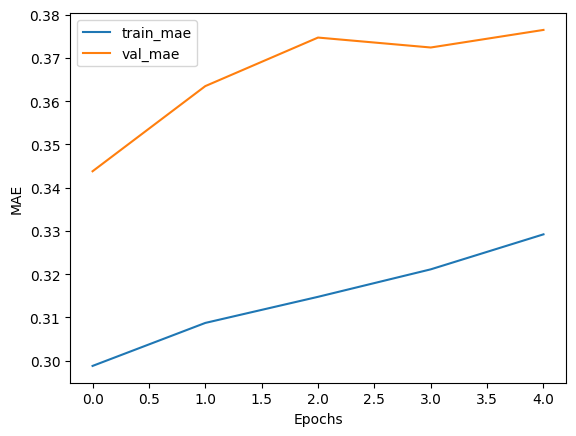

7/7 [==============================] - 0s 11ms/step
LSTM with Attention MAE: 2.552464851449063
LSTM with Attention MSE: 9.839937596389134
Training Base model 12...
Epoch 1/5
33/33 [==============================] - 3s 43ms/step - loss: 1.3783 - mean_absolute_error: 0.3127 - val_loss: 1.1583 - val_mean_absolute_error: 0.5721
Epoch 2/5
33/33 [==============================] - 1s 37ms/step - loss: 1.3692 - mean_absolute_error: 0.3141 - val_loss: 1.1294 - val_mean_absolute_error: 0.5666
Epoch 3/5
33/33 [==============================] - 1s 37ms/step - loss: 1.3630 - mean_absolute_error: 0.3214 - val_loss: 1.2581 - val_mean_absolute_error: 0.5947
Epoch 4/5
33/33 [==============================] - 1s 37ms/step - loss: 1.3517 - mean_absolute_error: 0.3183 - val_loss: 1.3651 - val_mean_absolute_error: 0.6068
Epoch 5/5
33/33 [==============================] - 1s 37ms/step - loss: 1.3592 - mean_absolute_error: 0.3308 - val_loss: 1.3289 - val_mean_absolute_error: 0.6086


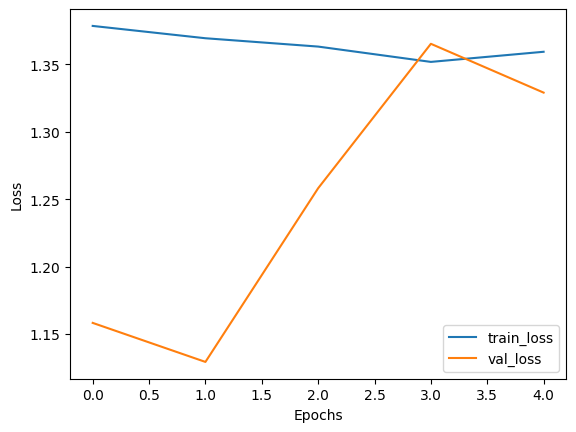

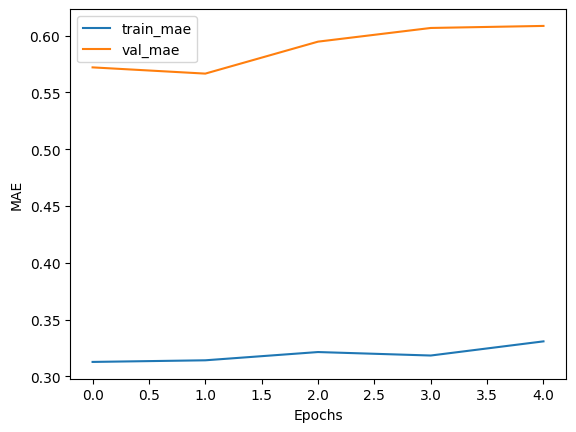

7/7 [==============================] - 0s 10ms/step
Base model 12 MAE: 3.9891345008228307
Base model 12 MSE: 34.48452086014187
Training Vanilla LSTM layer...
Epoch 1/10
33/33 [==============================] - 2s 21ms/step - loss: 1.4593 - mean_absolute_error: 0.2877 - val_loss: 0.4685 - val_mean_absolute_error: 0.2472
Epoch 2/10
33/33 [==============================] - 0s 15ms/step - loss: 1.4551 - mean_absolute_error: 0.3041 - val_loss: 0.4710 - val_mean_absolute_error: 0.2525
Epoch 3/10
33/33 [==============================] - 0s 15ms/step - loss: 1.4537 - mean_absolute_error: 0.3050 - val_loss: 0.4726 - val_mean_absolute_error: 0.2557
Epoch 4/10
33/33 [==============================] - 0s 15ms/step - loss: 1.4520 - mean_absolute_error: 0.3048 - val_loss: 0.4742 - val_mean_absolute_error: 0.2589
Epoch 5/10
33/33 [==============================] - 0s 15ms/step - loss: 1.4504 - mean_absolute_error: 0.3054 - val_loss: 0.4757 - val_mean_absolute_error: 0.2618
Epoch 6/10
33/33 [=========

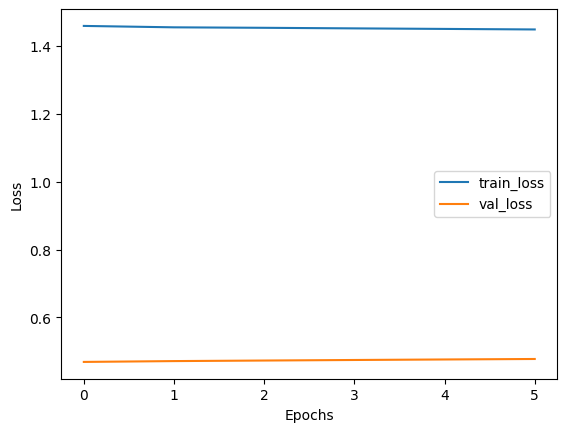

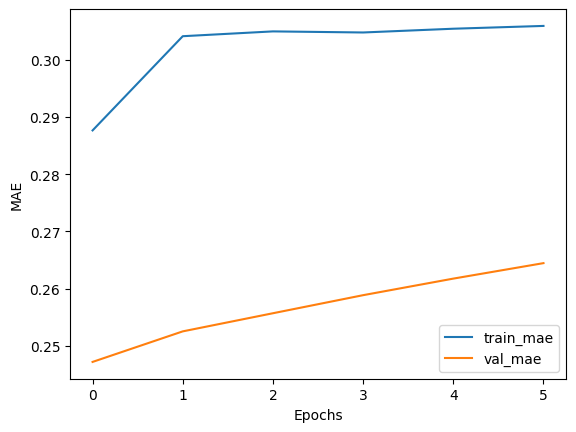

7/7 [==============================] - 0s 6ms/step
Vanilla LSTM layer MAE: 0.36317168879879397
Vanilla LSTM layer MSE: 0.14811208036701157
Training Base model 4...
Epoch 1/10
33/33 [==============================] - 2s 26ms/step - loss: 1.2451 - mean_absolute_error: 0.2830 - val_loss: 0.7126 - val_mean_absolute_error: 0.4141
Epoch 2/10
33/33 [==============================] - 1s 17ms/step - loss: 1.2260 - mean_absolute_error: 0.3141 - val_loss: 0.7378 - val_mean_absolute_error: 0.4181
Epoch 3/10
33/33 [==============================] - 1s 17ms/step - loss: 1.2558 - mean_absolute_error: 0.3127 - val_loss: 0.7006 - val_mean_absolute_error: 0.3884
Epoch 4/10
33/33 [==============================] - 1s 17ms/step - loss: 1.2501 - mean_absolute_error: 0.3017 - val_loss: 0.7529 - val_mean_absolute_error: 0.4302
Epoch 5/10
33/33 [==============================] - 1s 17ms/step - loss: 1.2026 - mean_absolute_error: 0.3115 - val_loss: 0.7518 - val_mean_absolute_error: 0.4201
Epoch 6/10
33/33 [===

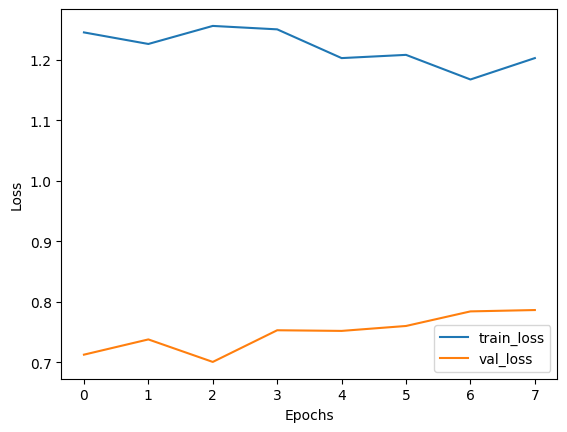

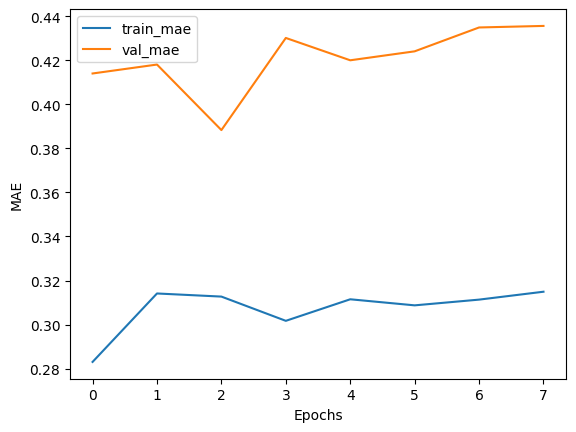

7/7 [==============================] - 0s 4ms/step
Base model 4 MAE: 0.47591282806156743
Base model 4 MSE: 0.26842063833196106
Training Gated Recurrent Unit (GRU)...
Epoch 1/10
33/33 [==============================] - 2s 23ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 2/10
33/33 [==============================] - 1s 17ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 3/10
33/33 [==============================] - 1s 17ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 4/10
33/33 [==============================] - 1s 17ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 5/10
33/33 [==============================] - 1s 17ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 6/10
33/33 [=

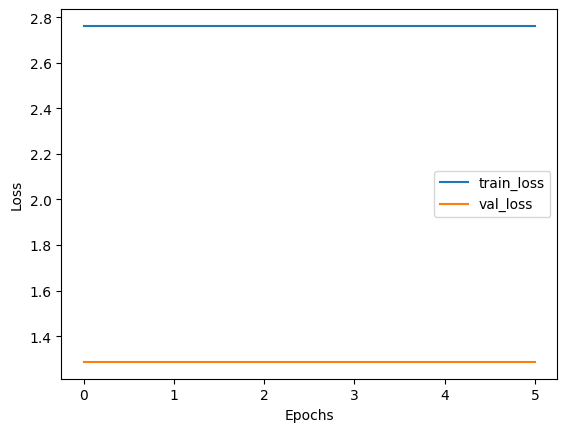

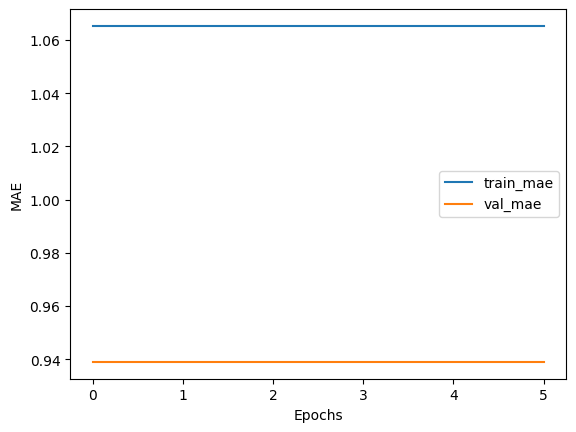

7/7 [==============================] - 0s 4ms/step
Gated Recurrent Unit (GRU) MAE: 0.8994022236788763
Gated Recurrent Unit (GRU) MSE: 0.8089243599585069
Training Bidirectional LSTM (BiLSTM)...
Epoch 1/10
33/33 [==============================] - 4s 46ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 2/10
33/33 [==============================] - 1s 35ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 3/10
33/33 [==============================] - 1s 34ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 4/10
33/33 [==============================] - 1s 34ms/step - loss: 2.7615 - mean_absolute_error: 1.0653 - val_loss: 1.2870 - val_mean_absolute_error: 0.9390
Epoch 5/10
11/33 [=========>....................] - ETA: 0s - loss: 0.8089 - mean_absolute_error: 0.8994

KeyboardInterrupt: 

In [968]:
# Specify the file path
file_path = "experiment.txt"  # Replace with your desired file path
epoch = [5,10,30,50,80,100,250,500,800,1000,1200,1500,2000,2500]
for e in epoch: 
    # Iterate through models, train, and evaluate
    for model_name, build_model_fn in models:
        print(f"Training {model_name}...")
        history = compile_and_fit(build_model_fn,X_train,y_train, epochs=e)
        name = f"{model_name}_{e}"
        plot_training_history(history,name)
        # history.model = build_model_fn(X_train.shape[1:], 1)  # Output dimension is 1 for regression
        # history.model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        
        y_pred = history.model.predict(X_test)
        # Calculate MAE and MSE
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        report = f"At epoch {e} {model_name} has MAE: {mae} and MSE {mse}\n "
        with open(file_path, 'a') as file:
            file.write("\n" + report)

        print(f"{model_name} MAE: {mae}")
        print(f"{model_name} MSE: {mse}")
        print("=" * 50)

In [ ]:
import re

# Specify the file path
file_path = 'experiment.txt'  # Replace with the path to your file

# Initialize an empty string to store the file content
file_content = ''

# Open the file for reading
try:
    with open(file_path, 'r') as file:
        # Read the entire content of the file and store it in the string
        file_content = file.read()
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Now, 'file_content' contains the content of the file as a string
print(file_content)



# Define a regular expression pattern to match the data
pattern = r"At epoch (\d+) (.+?) has MAE: ([\d.]+) and MSE ([\d.]+)"

# Use regex to find all matches in the text
matches = re.findall(pattern, file_content)

# Create a list of dictionaries to structure the data
structured_data = []

# Loop through the matches and structure the data
for match in matches:
    epoch = int(match[0])
    model_name = match[1]
    mae = float(match[2])
    mse = float(match[3])
    
    entry = {
        "Epoch": epoch,
        "Model": model_name,
        "MAE": mae,
        "MSE": mse
    }
    
    structured_data.append(entry)

# # Print the structured data
# for entry in structured_data:
#     print(entry)

df = pd.DataFrame(structured_data)
# Set Pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the DataFrame
print(df)


At epoch 5 Vanilla LSTM layer has MAE: 0.3280789706739402 and MSE 0.13816786610081833
 
At epoch 5 Base model 4 has MAE: 0.05798306354140279 and MSE 0.008036349865250291
 
At epoch 5 Gated Recurrent Unit (GRU) has MAE: 0.8994022236788763 and MSE 0.8089243599585069
 
At epoch 5 Bidirectional LSTM (BiLSTM) has MAE: 0.8994022236788763 and MSE 0.8089243599585069
 
At epoch 5 Stacked LSTM has MAE: 0.8994022236788763 and MSE 0.8089243599585069
 
At epoch 5 LSTM with Attention has MAE: 0.4727928319084931 and MSE 0.44303726543362554
 
At epoch 5 Base model 12 has MAE: 0.40956859782439026 and MSE 0.34385056942918235
 
At epoch 10 Vanilla LSTM layer has MAE: 0.2924477558161855 and MSE 0.10915758773476995
 
At epoch 10 Base model 4 has MAE: 0.07982858281969218 and MSE 0.01156221896747716
 
At epoch 10 Gated Recurrent Unit (GRU) has MAE: 0.8994022236788763 and MSE 0.8089243599585069
 
At epoch 10 Bidirectional LSTM (BiLSTM) has MAE: 0.8994022236788763 and MSE 0.8089243599585069
 
At epoch 10 Stac

In [ ]:
# Reset the display options to their defaults
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


# Create a bar chart for MAE values by model
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="MAE", data=df)
plt.title("MAE by Model")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Create a line plot for MSE values by epoch
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="MSE", hue="Model", data=df)
plt.title("MSE by Epoch")
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
%pip install plotly
%pip install --upgrade nbformat

import pandas as pd
import plotly.express as px

# Create a bar chart for MAE values by model using Plotly Express
bar_chart = px.bar(df, x="Model", y="MAE", title="MAE by Model", labels={"MAE": "Mean Absolute Error"})
bar_chart.update_xaxes(categoryorder="total ascending")

# Create a line plot for MSE values by epoch using Plotly Express
line_plot = px.line(df, x="Epoch", y="MSE", color="Model", title="MSE by Epoch", labels={"MSE": "Mean Squared Error"})
line_plot.update_xaxes(type='category')

# Show the plots
bar_chart.show()
line_plot.show()
